In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from jax import config
import jax.numpy as jnp
import numpy as np
from opentn.utils import plot_pretty
config.update("jax_enable_x64", True)

In [24]:
from opentn.states.qubits import X, Y, Z, I
import numpy as np
from opentn.transformations import lindbladian2super, super2choi, choi2kraus, vectorize_dissipative, create_2local_liouvillians, create_trotter_layers
from opentn.optimization import compute_trotter_approximation_error
import matplotlib.pyplot as plt

p = 0.2
w =  1 - p
gamma = -0.5 * np.log(1 - 2 * p)

# Preliminary tests

In [10]:
test_super = (gamma/4) * (np.kron(X, X) - np.kron(I, I))
super_x =lindbladian2super(Li=[np.sqrt(gamma/4)*X])
if not np.allclose(test_super, super_x):
    print(test_super)
    print(super_x)
else:
    print(True)

True


In [11]:
test_super = (gamma/4) * (np.kron(Y, Y.conj()) - np.kron(I, I))
super_y = vectorize_dissipative(L=np.sqrt(gamma/4)*Y)
if not np.allclose(test_super, super_y):
    print(test_super)
    print(super_y)
else:
    print(True)

True


In [12]:
super_z =lindbladian2super(Li=[np.sqrt(gamma/4)*Z])
super_total = super_x + super_y + super_z
test_super_full = (gamma/4) * (np.kron(X, X) + np.kron(Y, Y.conj()) + np.kron(Z, Z) - 3*np.kron(I, I))
if not np.allclose(test_super_full, super_total):
    print(test_super_full)
    print(super_total)
else:
    print(True)
super_full_test = lindbladian2super(Li=[np.sqrt(gamma/4) * op for op in [X, Y, Z]])
np.allclose(super_full_test, super_total)

True


True

In [13]:
np.kron(Y, Y.conj()).imag, Y.imag

(array([[ 0.,  0., -0.,  0.],
        [ 0.,  0., -0., -0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]),
 DeviceArray([[ 0., -1.],
              [ 1.,  0.]], dtype=float64))

In [14]:
(lindbladian2super(Li=[np.sqrt(gamma/4) * op for op in [Y]]), test_super)

(array([[-0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25+0.j,  0.  +0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25+0.j,  0.  +0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j]]),
 array([[-0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25-0.j,  0.  +0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25+0.j,  0.  +0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j]]))

In [16]:
# Eks = choi2kraus(super2choi(exp_Lvec), tol=1e-15)
# len(Eks), Eks

In [146]:
np.sqrt(w**3 + (1-w)**3 + 2*(1-w)*w**2 + 2*w*(1-w)**2)

0.9165151389911681

# Creating Pauli lindbladians

In [26]:
# create a new sparse pauli lindbladian noise channel just to see whats up
# instead of the kitev lindbladian I should have paulis
N = 4
d = 2
tau = 1
gamma = 1

L0 = np.sqrt(gamma)*(np.kron(X, I) - np.kron(I, X))
L1 = np.sqrt(gamma)*(np.kron(Z, I) - np.kron(I, Z))
Li = [L0, L1]
# now to get the odd, even, and full layers for each of them and add them
Lvec_odd_full = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
Lvec_even_full = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)

for op in Li:
   _, Lvec_odd, Lvec_even = create_2local_liouvillians(Li=op, N=N, d=d, pbc=True)
   Lvec_odd_full += Lvec_odd
   Lvec_even_full += Lvec_even

Lvec_full = Lvec_odd_full + Lvec_even_full
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec_full, Lvec_odd_full, Lvec_even_full], tau=tau)

# Checking sum of Paulis

In [292]:
(X-Z)@(X-Z), L0@L0

DeviceArray([[2.+0.j, 0.+0.j],
             [0.+0.j, 2.+0.j]], dtype=complex128)

In [287]:
# They are not pauli
print(np.allclose(np.eye(4), L0@L0))
print(np.allclose(np.eye(4), L1@L1))
# but they are hermitian
print(np.allclose(L0, L0.T))
print(np.allclose(L1, L1.T))
# are they unitary
print(np.allclose(np.eye(4), L0@L0.T))
print(np.allclose(np.eye(4), L1@L1.T))


False
False
True
True
False
False


In [272]:
# So they do not commute and do not have the property they suggested
np.allclose(np.kron(L0, L0.T)@np.kron(L1, L1.T), np.kron(L1, L1.T)@np.kron(L0, L0.T))

False

In [215]:
from math import log
int(log(L0.shape[0], d))

2

In [297]:
Eks = choi2kraus(super2choi(exp_Lvec), tol=1e-15)
print(len(Eks))
# interesting, it is actually what we expect I think.
Eks_even = choi2kraus(super2choi(exp_Lvec_even), tol=1e-15)
len(Eks_even)

256


100

In [481]:
2**8

256

In [340]:
for superoperator in [exp_Lvec_odd, exp_Lvec_even, exp_Lvec, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd]:
    choi = super2choi(superoperator)
    print(np.linalg.matrix_rank(choi))

100
100
256
256


# Now the optimization part

In [21]:
from opentn.stiefel import gradient_stiefel_vec, riemannian_hessian_vec, retract_stiefel
from opentn.optimization import frobenius_norm, model_stiefel_local
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')

In [17]:
# now I need to create an ansatz as I did for get_kitaev_trotter_local_ansatz
from opentn.transformations import super2ortho
from opentn.optimization import get_general_trotter_local_ansatz
superop_local_list = get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=2)
# just checking that now the rank has increase because we have more lindbladians.
# as expected, we have 2 lindbladians and we obtained 4 kraus operators?
print(np.linalg.matrix_rank(super2choi(superop_local_list[0])))

10


In [283]:
Eks_test = choi2kraus(super2choi(superop_local_list[0]), tol=1e-15)
P = Eks_test[0]
# it is hermitian
print(np.allclose(P, P.conj().T))
# but not unitary
print(np.allclose(np.eye(4), P@P.T))
print(np.allclose(np.eye(4), P.T@P))
# therefore not involutory

True
False
False


# Interlude from when writing thesis:
I want to verify that the odd and even layers are the same as then doing the tensoring and applying the pbc shift

In [245]:
# we want to check that the
# exp_Lvec_odd
# # and
# exp_Lvec_even
# are the same as when tensoring the models
from opentn.transformations import create_supertensored_from_local, convert_supertensored2liouvillianfull
superop_local_odd_even = get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)
superops_tensored = [create_supertensored_from_local(localop=op, N=N, pbc=True) for op in superop_local_odd_even]
# at this point the 0th and 1st layer are different only because we have a different time step, but no shift has happened so they should be the same
print([np.allclose(superops_tensored[0], superops_tensored[i]) for i in [1,2]])
op1 = superops_tensored[0]
op2 = exp_Lvec_odd
print(np.allclose(op1, op2), np.linalg.norm(op1 - op2))
print(np.allclose(convert_supertensored2liouvillianfull(op1, N=N, d=d, shift_pbc=False), op2))
print(np.max(superops_tensored[0] - exp_Lvec_odd), np.argmax(superops_tensored[0] - exp_Lvec_odd))


[False, True]
False 2.9662275302097645
True
(0.28501917848772346+0j) 23130


In [244]:
for L in Li:
    print(np.allclose(L, L.conj()))

op_test = superop_local_odd_even[0]
np.allclose(np.kron(op_test, op_test), superops_tensored[0])

True
True


True

In [247]:
op1 = superops_tensored[1]
op2 = exp_Lvec_even
print(np.allclose(op1, op2), np.linalg.norm(op1 - op2))
print(np.allclose(convert_supertensored2liouvillianfull(op1, N=N, d=d, shift_pbc=True), op2))

False 2.856382277723717
True


In [249]:
op_test = superop_local_odd_even[1]
np.allclose(np.kron(op_test, op_test), op1)

True

In [251]:
from opentn.transformations import get_indices_supertensored2liouvillianfull, permute_cyclic
N = 4
get_indices_supertensored2liouvillianfull(4), permute_cyclic(list(range(N)), 1) + permute_cyclic(list(range(N,2*N)), 1)

(([2, 3, 10, 11], [4, 5, 12, 13]), [1, 2, 3, 0, 5, 6, 7, 4])

Conclusion:
Both for the odd and even layers it works to start tensoring everything, then converting from local-global vectorization.
For the even layer we additionally have to shift the operators around from N to 0. This is done properly by me :)
Why does it not work just tensoring? The problem I think is that we don't have one single D1 and D2 operators, but we have rather a tensor with extra indices
for the k Lindblad operators and for the 3 terms inside the D1 and D2 components of D (3 terms). This means that tensoring D1 X D2 != D1 X D2 because we are not taking into account those extra legs that are going from D1 to D2.

# Rank 10

In [108]:
xs_timestep_1 = [super2ortho(x.real, rank=10) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)]
print(f_stiefel(xs_timestep_1))

0.11294517951068227


In [56]:
xs_timestep_1_opt, f_timestep_1_opt, radius_timestep_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1, save_x=True, niter=40)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.11294517951068227
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.11227828473846403
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.11124027887142852
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.11014318479356361
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.10950271927346032
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.10944128179858796
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.10839773093187999
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.10388040427317645
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.07727139116891082
radius 0.1
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.05324364413341802
radius 0.1
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.0428471166557

In [456]:
xs_timestep_1_opt_2, f_timestep_1_opt_2, radius_timestep_1_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_opt[-1], save_x=False, niter=20, radius_init=radius_timestep_1_opt
    )

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.0058728195704234164
rho: 0.5876795977599744 radius: 0.1
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.005778871897411835
rho: -0.5236906118539224 radius: 0.025
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.005778871897411835
rho: 0.9397311116139868 radius: 0.05
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.005643402542194052
rho: 0.8868503567017673 radius: 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.005574154787718574
rho: 0.5776603369436251 radius: 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.005480981288878907
rho: -0.8856125092414736 radius: 0.025
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.005480981288878907
rho: 0.9868468242728201 radius: 0.05
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.0053483512760430715
rho: 0.9510766909685129 radius: 0.1
iteration: 8
column : 0
column : 1
column : 2


In [466]:
xs_timestep_1_opt_3, f_timestep_1_opt_3, radius_timestep_1_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_opt_2[-1], save_x=False, niter=20, radius_init=radius_timestep_1_opt_2
    )

iteration: 0
column : 0
column : 1
column : 2
f(x0): 0.004812496118490269
rho: 1.0170701032882894 updated radius: 0.05
iteration: 1
column : 0
column : 1
column : 2
f(x1): 0.004766379762551717
rho: 0.9652612624204291 updated radius: 0.1
iteration: 2
column : 0
column : 1
column : 2
f(x2): 0.004742414568100972
rho: 0.8998071120369809 updated radius: 0.1
iteration: 3
column : 0
column : 1
column : 2
f(x3): 0.0046870520943602355
rho: 0.47463978482326713 updated radius: 0.1
iteration: 4
column : 0
column : 1
column : 2
f(x4): 0.0046494454678786615
rho: -4.3560537888667765 updated radius: 0.025
iteration: 5
column : 0
column : 1
column : 2
f(x5): 0.0046494454678786615
rho: 0.9308294863821043 updated radius: 0.05
iteration: 6
column : 0
column : 1
column : 2
f(x6): 0.0045882631461204235
rho: 0.9116342128071975 updated radius: 0.1
iteration: 7
column : 0
column : 1
column : 2
f(x7): 0.004567108904661737
rho: -1.3930557319084707 updated radius: 0.025
iteration: 8
column : 0
column : 1
column :

# Rank 5

In [302]:
xs_timestep_1_rank5 = [super2ortho(x.real, rank=5) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)]
print(f_stiefel(xs_timestep_1_rank5))

0.8621177224542576


In [488]:
from opentn.transformations import ortho2super
superops_local_test = [ortho2super(x) for x in xs_timestep_1_rank5]
# we assume the same operator acts on all sites (unlike before for even layer)
superops_full_split_test = [create_supertensored_from_local(localop=op, N=N, pbc=True) for op in superops_local_test]
superop_test = convert_supertensored2liouvillianfull(superops_full_split_test[2], N=N, d=d, shift_pbc=False)
np.linalg.matrix_rank(super2choi(superop_test))

25

In [303]:
# repeat the same optimization but with less rank
xs_timestep_1_rank5_opt, f_timestep_1_rank_5_opt, radius_timestep_1_rank5_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank5, save_x=False, niter=40)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.8621177224542576
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.7302253009088869
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.7096413977107365
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.6698942206699636
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.596638829707744
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.5179795673519623
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.4542492281729009
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.4036701402777079
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.3626646131437365
radius 0.1
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.3293741422986109
radius 0.1
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.3034101679260903
radius 

In [305]:
# second round with this rank
xs_timestep_1_rank5_opt_2, f_timestep_1_rank_5_opt_2, radius_timestep_1_rank5_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank5_opt[-1], save_x=False, niter=40, radius_init=radius_timestep_1_rank5_opt
    )

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.05299782615405049
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.04989565724413955
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.04733926516634118
radius 0.1
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.045184913514814525
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.04334732490239328
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.041731546948854066
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.040352368445332236
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.038991235149729506
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.03746087214292547
radius 0.1
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.036261947610537915
radius 0.1
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.03517539726

In [315]:
# third round with this rank
xs_timestep_1_rank5_opt_3, f_timestep_1_rank_5_opt_3, radius_timestep_1_rank5_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank5_opt_2[-1], save_x=False, niter=40, radius_init=radius_timestep_1_rank5_opt_2
    )

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.0136393770798342
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.013618983369123955
radius 0.025
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.013618983369123955
radius 0.05
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.013608898299968432
radius 0.05
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.01360150428289062
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.013587409418402911
radius 0.025
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.013587409418402911
radius 0.05
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.01357461735933267
radius 0.0125
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.01357461735933267
radius 0.025
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.013569901295703438
radius 0.05
iteration: 10
column : 0
column : 1
column : 2
cost function: 

# Rank 2

In [312]:
xs_timestep_1_rank2 = [super2ortho(x.real, rank=2) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)]
print(f_stiefel(xs_timestep_1_rank2))

0.9934460692854122


In [313]:
# repeat the same optimization but with less rank
xs_timestep_1_rank2_opt, f_timestep_1_rank2_opt, radius_timestep_1_rank2_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank2, save_x=False, niter=80)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 0.000625
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 0.00015625
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 3.90625e-05
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 9.765625e-06
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 2.44140625e-06
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 6.103515625e-07
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 1.52587890625e-07
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 3.814697265625e-08
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.9934460692854122
radius 9.53674316

In [487]:
from opentn.transformations import ortho2super
superops_local_test = [ortho2super(x) for x in xs_timestep_1_rank2]
# we assume the same operator acts on all sites (unlike before for even layer)
superops_full_split_test = [create_supertensored_from_local(localop=op, N=N, pbc=True) for op in superops_local_test]
superop_test = convert_supertensored2liouvillianfull(superops_full_split_test[2], N=N, d=d, shift_pbc=False)
np.linalg.matrix_rank(super2choi(superop_test))

4

# Rank 16

In [320]:
xs_timestep_1_rank16 = [super2ortho(x.real, rank=16) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)]
print(f_stiefel(xs_timestep_1_rank16))

0.11294517951068225


In [322]:
# repeat the same optimization but with less rank
xs_timestep_1_rank16_opt, f_timestep_1_rank16_opt, radius_timestep_1_rank16_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank16, save_x=False, niter=20)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.11294517951068225
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.1122782847384639
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.11124027887142848
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.11014318479356318
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.10950271927344771
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.10943907815977263
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.10855067808522723
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.1036387174177488
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.09598662081915131
radius 0.1
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.08602718406949654
radius 0.1
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.074741372935211

In [324]:
# repeat the same optimization but with less rank
xs_timestep_1_rank16_opt_2, f_timestep_1_rank16_opt_2, radius_timestep_1_rank16_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank16_opt[-1], save_x=False, niter=40, radius_init=radius_timestep_1_rank16_opt
    )

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.011346433501907878
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.010355243089808085
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.009196204975442133
radius 0.1
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.00817076017001572
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.007456079712086774
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.006826555472156327
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.0062934698639815195
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.006092484332741355
radius 0.025
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.006092484332741355
radius 0.05
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.005685130148095032
radius 0.1
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.005

In [471]:
# repeat the same optimization but with less rank
xs_timestep_1_rank16_opt_3, f_timestep_1_rank16_opt_3, radius_timestep_1_rank16_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_rank16_opt_2[-1], save_x=False, niter=20, radius_init=radius_timestep_1_rank16_opt_2
    )

iteration: 0
column : 0
column : 1
column : 2
f(x0): 0.004166866666456185
rho: 0.9609915717108511 updated radius: 0.025
iteration: 1
column : 0
column : 1
column : 2
f(x1): 0.004131991015569288
rho: 0.9653072345646454 updated radius: 0.05
iteration: 2
column : 0
column : 1
column : 2
f(x2): 0.004117203961013106
rho: 0.7731555706356061 updated radius: 0.1
iteration: 3
column : 0
column : 1
column : 2
f(x3): 0.004094875153422848
rho: -2.8582590683467863 updated radius: 0.025
iteration: 4
column : 0
column : 1
column : 2
f(x4): 0.004094875153422848
rho: 0.9179470587797436 updated radius: 0.05
iteration: 5
column : 0
column : 1
column : 2
f(x5): 0.0040662573500025246
rho: 0.3643164853274614 updated radius: 0.05
iteration: 6
column : 0
column : 1
column : 2
f(x6): 0.004056324036782058
rho: 0.2373927959565141 updated radius: 0.0125
iteration: 7
column : 0
column : 1
column : 2
f(x7): 0.004042530245350898
rho: 0.9620600137319807 updated radius: 0.025
iteration: 8
column : 0
column : 1
column 

# Comparing ranks

In [493]:
superop_rank2 = model_stiefel_local(xs_timestep_1_rank2, N, d)
np.linalg.matrix_rank(super2choi(superop_rank2))

53

In [494]:
superop_rank2 = model_stiefel_local(xs_timestep_1_rank2_opt[-1], N, d)
np.linalg.matrix_rank(super2choi(superop_rank2))

53

In [495]:
superop_rank5 = model_stiefel_local(xs_timestep_1_rank5, N, d)
np.linalg.matrix_rank(super2choi(superop_rank5))

256

In [496]:
superop_rank5 = model_stiefel_local(xs_timestep_1_rank5_opt_3[-1], N, d)
np.linalg.matrix_rank(super2choi(superop_rank5))

256

In [497]:
superop_rank10 = model_stiefel_local(xs_timestep_1, N, d)
np.linalg.matrix_rank(super2choi(superop_rank10))

256

In [492]:
superop_rank16 = model_stiefel_local(xs_timestep_1_rank16, N, d)
np.linalg.matrix_rank(super2choi(superop_rank16))

256

In [394]:
f_pauli_ranks = [f_timestep_1_rank2_opt, f_timestep_1_rank_5_opt + f_timestep_1_rank_5_opt_2 + f_timestep_1_rank_5_opt_3[:20], f_timestep_1_opt + f_timestep_1_opt_2+f_timestep_1_opt_3, f_timestep_1_rank16_opt + f_timestep_1_rank16_opt_2+f_timestep_1_rank16_opt_3]
labels = ['rank 2', 'rank 5', 'rank 10', 'rank 16']
title = r"PSPL: $\tau = 1,  n = 1$"
comparions_value = f_timestep_1_opt[0]
fig = plot_pretty(f_pauli_ranks, labels=labels, ylabel="Cost Function Value", xlabel="Iteration", integers=True, title=title, legend_out=False, use_semilogy=True, comparison_value=comparions_value, idx_main=1)
# fig.savefig('../images/thesis/cost_ranks_pspl_n1.pdf')

NameError: name 'f_timestep_1_rank2_opt' is not defined

# Save more data

In [532]:
np.save(file="xs_pspl_n1_rank_16", arr=xs_timestep_1_rank16_opt_3[-1])
np.save(file="xs_pspl_n1_rank_10", arr=xs_timestep_1_opt_3[-1])
np.save(file="xs_pspl_n1_rank_5", arr=xs_timestep_1_rank5_opt_3[-1])




In [330]:
# save each of the 4 lines:
np.save(file="f_pspl_n1_rank_2", arr=np.array(f_pauli_ranks[0]))
np.save(file="f_pspl_n1_rank_5", arr=np.array(f_pauli_ranks[1]))
np.save(file="f_pspl_n1_rank_10", arr=np.array(f_pauli_ranks[2]))
np.save(file="f_pspl_n1_rank_16", arr=np.array(f_pauli_ranks[3]))


In [57]:
from opentn.stiefel import check_isometries
print(check_isometries(xs_timestep_1_opt[-1]))
for op in xs_timestep_1_opt[-1]:
    print(op.shape)

[True, True, True]
(40, 4)
(40, 4)
(40, 4)


# Higher time steps

In [424]:
xs_timestep_2 = [super2ortho(x.real, rank=10) for x in  get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=2)]
print(f_stiefel(xs_timestep_2))

0.025364389491241437


In [58]:
xs_timestep_2_opt, f_timestep_2_opt, radius_timestep_2_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2, save_x=True, niter=40)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.025364389491241437
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.024737191920668953
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.023722846514555883
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.02259987548024324
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.021864762933163064
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.021314025580864666
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.020822831100467724
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.02060339308308139
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
cost functi

In [426]:
xs_timestep_2_opt_2, f_timestep_2_opt_2, radius_timestep_2_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_opt[-1], save_x=False, niter=20, radius_init=radius_timestep_2_opt
    )

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0016109174379209238
radius 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0015419745819796142
radius 0.05
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.001512169510205334
radius 0.1
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0014481892639927748
radius 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0014481892639927748
radius 0.05
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0014040503157314022
radius 0.0125
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0014040503157314022
radius 0.025
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0013743626187685157
radius 0.05
iteration: 8
column : 0
column : 1
column : 2
column : 3
colu

In [59]:
xs_timestep_3 = [super2ortho(x.real, rank=10) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=3)]
print(f_stiefel(xs_timestep_3))

0.010857033765052185


In [63]:
xs_timestep_3_opt, f_timestep_3_opt, radius_timestep_3_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3, save_x=False, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.010857033765052185
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.010437217250439269
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.009877584428447942
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.009482255059592295
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.009112739407732703
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.00834657156389041
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.007892306565641341
radius 0.1
iteration: 7
column : 0
column : 1
colu

In [84]:
xs_timestep_3_opt_2, f_timestep_3_opt_2, radius_timestep_3_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_opt[-1], save_x=False, niter=20, radius_init=radius_timestep_3_opt)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0021216495225596338
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001969309682688608
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001772324534805612
radius 0.1
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001586106577121945
radius 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001586106577121945
radius 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0014150562431183744
radius 0.05
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0013456700483884503
radius 0.1
iteration: 7
column : 0
column : 

In [404]:
xs_timestep_3_opt_3, f_timestep_3_opt_3, radius_timestep_3_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_opt_2[-1], save_x=False, niter=10, radius_init=radius_timestep_3_opt_2)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005814739387758306
radius 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005587267523123908
radius 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005501926488940806
radius 0.025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005425243944974175
radius 0.00625
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005425243944974175
radius 0.0125
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005300569872021077
radius 0.025
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005250106195302092
radius 0.05
iteration: 7
colum

In [451]:
xs_timestep_3_opt_4, f_timestep_3_opt_4, radius_timestep_3_opt_4 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_opt_3[-1], save_x=False, niter=10, radius_init=radius_timestep_3_opt_3)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.00048176678390651203
rho: 0.7289349867773751 radius: 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0004733154092625859
rho: 0.4469292148721922 radius: 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.00046502666651404887
rho: -0.1033311552458749 radius: 0.00625
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.00046502666651404887
rho: 0.9210568593434033 radius: 0.0125
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.00045110852768407805
rho: 0.9666960733335944 radius: 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0004443680523584391
rho: 0.9106258633474232 radius: 0.05
ite

In [387]:
xs_timestep_4 = [super2ortho(x.real, rank=10) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=4)]
print(f_stiefel(xs_timestep_4))

0.006111769709018304


In [343]:
xs_timestep_4_opt, f_timestep_4_opt, radius_timestep_4_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4, save_x=False, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.006111769709018304
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.005857116300686238
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.005496508947203655
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0052450778978730215
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0049186174254839945
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.004392952582241875
radius 0.1
iteration: 6
column : 0
column : 1
column

In [354]:
xs_timestep_4_opt_2, f_timestep_4_opt_2, radius_timestep_4_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_opt[-1], save_x=False, niter=20, radius_init=radius_timestep_4_opt)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0017751549113047486
radius 0.05
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0016589163034766317
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0014945362063963354
radius 0.025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0014945362063963354
radius 0.05
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0014278374827709423
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0013455089413730186
radius 0.1
iteration: 6
column : 0
column : 1
c

In [409]:
xs_timestep_4_opt_3, f_timestep_4_opt_3, radius_timestep_4_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_opt_2[-1], save_x=False, niter=10, radius_init=radius_timestep_4_opt_2)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0006582175694576067
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0005953445366043063
radius 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0005953445366043063
radius 0.05
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.000537643334263514
radius 0.05
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0004935995368255012
radius 0.0125
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0004935995368255012
radius 0.025
iteration: 6
column : 0
column :

In [416]:
xs_timestep_4_opt_4, f_timestep_4_opt_4, radius_timestep_4_opt_4 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_opt_3[-1], save_x=False, niter=10, radius_init=radius_timestep_4_opt_3)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00037908958026625566
radius 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00036873664780015243
radius 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0003593261131220403
radius 0.00625
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0003593261131220403
radius 0.0125
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0003423398940062425
radius 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00033639608768919443
radius 0.05
iteration: 6
column : 0

In [464]:
xs_timestep_4_opt_5, f_timestep_4_opt_5, radius_timestep_4_opt_5 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_opt_4[-1], save_x=False, niter=10, radius_init=radius_timestep_4_opt_4)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function at 0-iteration: 0.00031018697330318246
rho: 0.8854282903684263 updated radius: 0.0125
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function at 1-iteration: 0.0002959403960776708
rho: 0.9622921590083198 updated radius: 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function at 2-iteration: 0.00029007320044050123
rho: 0.8538355610689318 updated radius: 0.05
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function at 3-iteration: 0.0002797351189451438
rho: -2.7230061905788645 updated radius: 0.0125
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function at 4-iteration: 0.000279735118

# Save data

In [533]:
np.save(file="x_pauli_n2_tau1_rank10", arr=xs_timestep_2_opt_2[-1])
np.save(file="x_pauli_n3_tau1_rank10", arr=xs_timestep_3_opt_4[-1])
np.save(file="x_pauli_n4_tau1_rank10", arr=xs_timestep_4_opt_5[-1])


In [457]:
f_stiefel_ts = [f_timestep_1_opt+f_timestep_1_opt_2, f_timestep_2_opt+f_timestep_2_opt_2, f_timestep_3_opt + f_timestep_3_opt_2 + f_timestep_3_opt_3+f_timestep_3_opt_4, f_timestep_4_opt+f_timestep_4_opt_2+f_timestep_4_opt_3+f_timestep_4_opt_4]

In [459]:
np.save(file="f_pauli_n4_tau1_rank10", arr=np.array(f_stiefel_ts[-1]))
np.save(file="f_pauli_n3_tau1_rank10", arr=np.array(f_stiefel_ts[-2]))
np.save(file="f_pauli_n2_tau1_rank10", arr=np.array(f_stiefel_ts[-3]))
np.save(file="f_pauli_n1_tau1_rank10", arr=np.array(f_stiefel_ts[-4]))

In [ ]:
np.save(file="xs_pspl_n1_rank_10", arr=xs_timestep_1_opt_3[-1])
np.save(file="f_pspl_n1_rank_10", arr=np.array(f_pauli_ranks[2]))

# Load data

In [11]:
f_pauli_n4_tau1_rank10 = np.load("f_pauli_n4_tau1_rank10.npy")
f_pauli_n3_tau1_rank10 = np.load("f_pauli_n3_tau1_rank10.npy")
f_pauli_n2_tau1_rank10 = np.load("f_pauli_n2_tau1_rank10.npy")
f_pauli_n1_tau1_rank10 = np.load("f_pspl_n1_rank_10.npy")



In [7]:
xs_pspl_n1_rank_10 = np.load("xs_pspl_n1_rank_10.npy")
xs_pspl_n1_rank_10 = list(xs_pspl_n1_rank_10)

In [12]:
f_pauli_n1_tau1_3 = [
    0.004812496118490269,
    0.004766379762551717,
    0.004742414568100972,
    0.0046870520943602355,
    0.0046494454678786615,
    0.0046494454678786615,
    0.0045882631461204235,
    0.004567108904661737,
    0.004567108904661737,
    0.004549686945289479,
    0.004535839163188282,
    0.004535839163188282,
    0.004518864316645236,
    0.004518864316645236,
    0.004513371384317128,
    0.0045068233370126705,
    0.004496934768903939,
    0.004496934768903939,
    0.004483227419030374,
    0.0044788174383502705
]
f_pauli_n1_tau1_rank10 = np.hstack([f_pauli_n1_tau1_rank10, f_pauli_n1_tau1_3])

In [6]:
x_pauli_n2_tau1_rank10 = np.load("x_pauli_n2_tau1_rank10.npy")
x_pauli_n2_tau1_rank10 = list(x_pauli_n2_tau1_rank10)

# Loading data generated on secondary branch

In [13]:
xs_timestep_1_opt_4 = np.load("xs_timestep_1_opt_4.npy")
xs_timestep_1_opt_4 = list(xs_timestep_1_opt_4)

f_timestep_1_opt_4 = np.load("f_timestep_1_opt_4.npy")

# Extra optimization of step 2

In [64]:
xs_timestep_2_opt_3, f_timestep_2_opt_3, radius_timestep_2_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, x_pauli_n2_tau1_rank10, save_x=False, niter=20, radius_init=0.05)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
f(x0): 0.0011241263590056653
rho: 0.7004405469093743 updated radius: 0.05
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
f(x1): 0.0011004182415611302
rho: -3.0422251601751573 updated radius: 0.0125
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
f(x2): 0.0011004182415611302
rho: 0.9659992103990523 updated radius: 0.025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
f(x3): 0.0010696863424801944
rho: 0.5487076132269566 updated radius: 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
f(x4): 0.0010622140120970143
rho: 0.8235819207044001 updated radius: 0.05
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
f(x5): 0.0010409350477205916
rho: -3.391211539875127 updated radius: 0.0125
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
f(x6): 0.0010409350477205916
rho: 0.9476455835053603 updated radius: 0.02

In [22]:
# Data saved from text in output:
f_timestep_2_opt_3 = [
    0.0011241263590056653,
    0.0011004182415611302,
    0.0011004182415611302,
    0.0010696863424801944,
    0.0010622140120970143,
    0.0010409350477205916,
    0.0010409350477205916,
    0.0010262360116571406,
    0.0010135858447148807,
    0.0009865128718342833,
    0.0009865128718342833,
    0.0009865128718342833,
    0.0009693094663644459,
    0.000961990509013058,
    0.0009509682498635295,
    0.0009509682498635295,
    0.0009404266844284814,
    0.0009324864069568056,
    0.0009324864069568056,
    0.0009209011578363118
]


In [14]:
xs_timestep_2_opt_4, f_timestep_2_opt_4, radius_timestep_2_opt_4 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_opt_3[-1], save_x=False, niter=20, radius_init=radius_timestep_2_opt_3)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x0): 0.0004093865830950871
rho: 0.9338386307378828 updated radius: 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x1): 0.0003975223591153064
rho: 0.782503946125473 updated radius: 0.05
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x2): 0.0003875298253448361
rho: -3.7310918696109994 updated radius: 0.0125
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x3): 0.0003875298253448361
rho: 0.8978790328440195 updated radius: 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x4): 0.00037361766624154937
rho: 0.7387432195654409 updated radius: 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x5): 0.0003632703674529928
rho: -0.30497850550429934 updated radius: 0.00625
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x6): 0.0003632703674529928
rho: 0.9401114473860755 updated radius: 0.0125
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x7): 0.0003524742484074451
rho: 0.9382556989762594 updated radius: 0.025
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x8): 0.0003466614513739498
rho: 0.8918581929195164 updated radius: 0.05
iteration: 9
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x9): 0.00033282875633571543
rho: -3.0363429854787887 updated radius: 0.0125
iteration: 10
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x10): 0.00033282875633571543
rho: 0.9165813746550425 updated radius: 0.025
iteration: 11
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x11): 0.00032186532121478113
rho: 0.30719264187042356 updated radius: 0.025
iteration: 12
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x12): 0.00031818777351428663
rho: -1.3120090802769666 updated radius: 0.00625
iteration: 13
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x13): 0.00031818777351428663
rho: 0.8831665334827528 updated radius: 0.0125
iteration: 14
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x14): 0.0003036806358843612
rho: 0.8867310992522509 updated radius: 0.025
iteration: 15
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x15): 0.0002988742569324557
rho: 0.900116829047734 updated radius: 0.05
iteration: 16
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x16): 0.0002893568168239828
rho: -9.567646522383788 updated radius: 0.0125
iteration: 17
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x17): 0.0002893568168239828
rho: 0.8238005243424644 updated radius: 0.025
iteration: 18
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x18): 0.00028139327198959947
rho: -0.8415696684193859 updated radius: 0.00625
iteration: 19
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x19): 0.00028139327198959947
rho: 0.9512297956492594 updated radius: 0.0125

In [15]:
f_timestep_2_opt_4 = [
    0.0009145487174456898,
    0.0009036110232064983,
    0.0009036110232064983,
    0.0008941044562063616,
    0.0008880693420151531,
    0.0008880693420151531,
    0.000875518248606732,
    0.0008700428932447551,
    0.0008610960489328429,
    0.0008409446218451901,
    0.0008409446218451901,
    0.0008363730271504886,
    0.0008162729481684871,
    0.0008110404823218044,
    0.0008024693140814736,
    0.0008024693140814736,
    0.0007936260428307093,
    0.0007876092628424429,
    0.0007821533144168196,
    0.0007821533144168196
]


# Extra optimization of step 3

In [265]:
x_pauli_n3_tau1_rank10 = np.load("x_pauli_n3_tau1_rank10.npy")
x_pauli_n3_tau1_rank10 = list(x_pauli_n3_tau1_rank10)

In [266]:
xs_timestep_3_opt_5, f_timestep_3_opt_5, radius_timestep_3_opt_5 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, x_pauli_n3_tau1_rank10, save_x=False, niter=20, radius_init=0.0125)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x0): 0.0004093865830950871
rho: 0.9338386307378828 updated radius: 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x1): 0.0003975223591153064
rho: 0.782503946125473 updated radius: 0.05
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x2): 0.0003875298253448361
rho: -3.7310918696109994 updated radius: 0.0125
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x3): 0.0003875298253448361
rho: 0.8978790328440195 updated radius: 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x4): 0.00037361766624154937
rho: 0.7387432195654409 updated radius: 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x5): 0.0003632703674529928
rho: -0.30497850550429934 updated radius: 0.00625
itera

In [16]:
f_timestep_3_opt_5 = [
    0.0004093865830950871,
    0.0003975223591153064,
    0.0003875298253448361,
    0.0003875298253448361,
    0.00037361766624154937,
    0.0003632703674529928,
    0.0003632703674529928,
    0.0003524742484074451,
    0.0003466614513739498,
    0.00033282875633571543,
    0.00033282875633571543,
    0.00032186532121478113,
    0.00031818777351428663,
    0.00031818777351428663,
    0.0003036806358843612,
    0.0002988742569324557,
    0.0002893568168239828,
    0.0002893568168239828,
    0.00028139327198959947,
    0.00028139327198959947
]


In [303]:
xs_timestep_3_opt_6, f_timestep_3_opt_6, radius_timestep_3_opt_6 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_opt_5[-1], save_x=False, niter=20, radius_init=radius_timestep_3_opt_5)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x0): 0.00027695093847279913
rho: 0.8947612242672549 updated radius: 0.025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x1): 0.0002733044033754342
rho: 0.7894949790646126 updated radius: 0.05
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x2): 0.0002671718977901601
rho: -20.804995467393656 updated radius: 0.0125
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x3): 0.0002671718977901601
rho: 0.55066002890294 updated radius: 0.0125
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x4): 0.0002627327465718535
rho: 0.32000921870255017 updated radius: 0.0125
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
f(x5): 0.0002604907159733867
rho: 0.22031879780745184 updated radius: 0.003125
ite

In [17]:
f_timestep_3_opt_6 = [
    0.00027695093847279913,
    0.0002733044033754342,
    0.0002671718977901601,
    0.0002671718977901601,
    0.0002627327465718535,
    0.0002604907159733867,
    0.00025867805612768294,
    0.00025314405516768635,
    0.0002514026863923016,
    0.00024871341976208204,
    0.00024519130762861634,
    0.00024519130762861634,
    0.0002404885566545557,
    0.0002382771994083426,
    0.0002382771994083426,
    0.0002362273352034104,
    0.00023427427222056144,
    0.00023427427222056144,
    0.00023230050630626022,
    0.00023033004221166163
]


In [314]:
from copy import copy
# f_timestep_3_opt_6 = copy(f_timestep_4_opt_6)
# f_timestep_3_opt_5 = copy(f_timestep_4_opt_5)

# Extra optimization of timestep 4

In [18]:
x_pauli_n4_tau1_rank10_opt = np.load("x_pauli_n4_tau1_rank10.npy")

In [25]:
x_pauli_n4_tau1_rank10_opt = list(x_pauli_n4_tau1_rank10_opt)

In [28]:
xs_timestep_4_opt_6, f_timestep_4_opt_6, radius_timestep_4_opt_6 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, x_pauli_n4_tau1_rank10_opt, save_x=False, niter=10, radius_init=0.05)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x0): 0.0002384849148234933
rho: -6.416247689252969 updated radius: 0.0125
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x1): 0.0002384849148234933
rho: 0.8843239290605623 updated radius: 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x2): 0.00022881492182543847
rho: -0.5822090816837541 updated radius: 0.00625
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x3): 0.00022881492182543847
rho: 0.9605483321282373 updated radius: 0.0125
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
f(x4): 0.0002249035333871975
rho: 0.9451647492947923 updated radius: 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
c

In [18]:
f_timestep_4_opt_6 = np.load("f_pauli_n4_tau1_rank10_2.npy")[-10:]
xs_timestep_4_opt_6 = np.load("x_pauli_n4_tau1_rank10_2.npy")
xs_timestep_4_opt_6 = list(xs_timestep_4_opt_6)

In [19]:
xs_timestep_4_opt_7 = np.load("xs_timestep_4_opt_7.npy")
xs_timestep_4_opt_7 = list(xs_timestep_4_opt_7)

f_timestep_4_opt_7 = np.load("f_timestep_4_opt_7.npy")

In [20]:
f_timestep_4_opt_8 = np.load("f_timestep_4_opt_8.npy")
f_timestep_4_opt_9 = np.load("f_timestep_4_opt_9.npy")

xs_timestep_4_opt_9 = np.load("xs_timestep_4_opt_9.npy")
xs_timestep_4_opt_9 = list(xs_timestep_4_opt_9)

# Gathering data

In [27]:
f_stiefel_ts = [np.hstack([f_pauli_n1_tau1_rank10, f_timestep_1_opt_4]), np.hstack([f_pauli_n2_tau1_rank10, f_timestep_2_opt_3, f_timestep_2_opt_4]), np.hstack([f_pauli_n3_tau1_rank10, f_timestep_3_opt_5, f_timestep_3_opt_6]), np.hstack([f_pauli_n4_tau1_rank10, f_timestep_4_opt_6, f_timestep_4_opt_7, f_timestep_4_opt_8, f_timestep_4_opt_9])]
error_stiefel = [values[-1] for values in f_stiefel_ts]
# should coincide with the non optimized
error_trotter = [compute_trotter_approximation_error(d, N, tau=1, n=n, Li=Li) for n in range(1,30)]

In [403]:
error_trotter[:5]

[DeviceArray(0.11294518, dtype=float64),
 DeviceArray(0.02536439, dtype=float64),
 DeviceArray(0.01085703, dtype=float64),
 DeviceArray(0.00611177, dtype=float64),
 DeviceArray(0.00393854, dtype=float64)]

In [369]:
ratios_ts = []
for f_opt in f_stiefel_ts:
    ratios_ts.append([cost/f_opt[0] for cost in f_opt])

In [404]:
[r[-1] for r in ratios_ts]

[0.03834023708069136,
 0.030836670233553402,
 0.021214822316669338,
 0.021814083289582373]

# Saving again up to 
* n=4: optimization 6
* n=3: optimization 5
* n=2: optimization 3

In [177]:
np.save(file="f_pauli_n4_tau1_rank10_2", arr=np.array(f_stiefel_ts[-1]))
np.save(file="f_pauli_n2_tau1_rank10_2", arr=np.array(f_stiefel_ts[-3]))
np.save(file="f_pauli_n1_tau1_rank10_2", arr=np.array(f_stiefel_ts[-4]))

In [178]:
np.save(file="x_pauli_n2_tau1_rank10_2", arr=xs_timestep_2_opt_3[-1])
np.save(file="x_pauli_n4_tau1_rank10_2", arr=xs_timestep_4_opt_6[-1])

In [302]:
np.save(file="f_pauli_n3_tau1_rank10_2", arr=np.array(f_stiefel_ts[-2]))
np.save(file="xs_timestep_3_opt_5", arr=xs_timestep_3_opt_5[-1])

# Saving again up to
* n=3: optimization 6
* n=4 (saved already on different branch up to optimization 9)
* n=2: optimization 4

In [345]:
np.save(file="f_timestep_3_opt_6", arr=f_timestep_3_opt_6)
np.save(file="xs_timestep_3_opt_6", arr=xs_timestep_3_opt_6[-1])

# Plotting

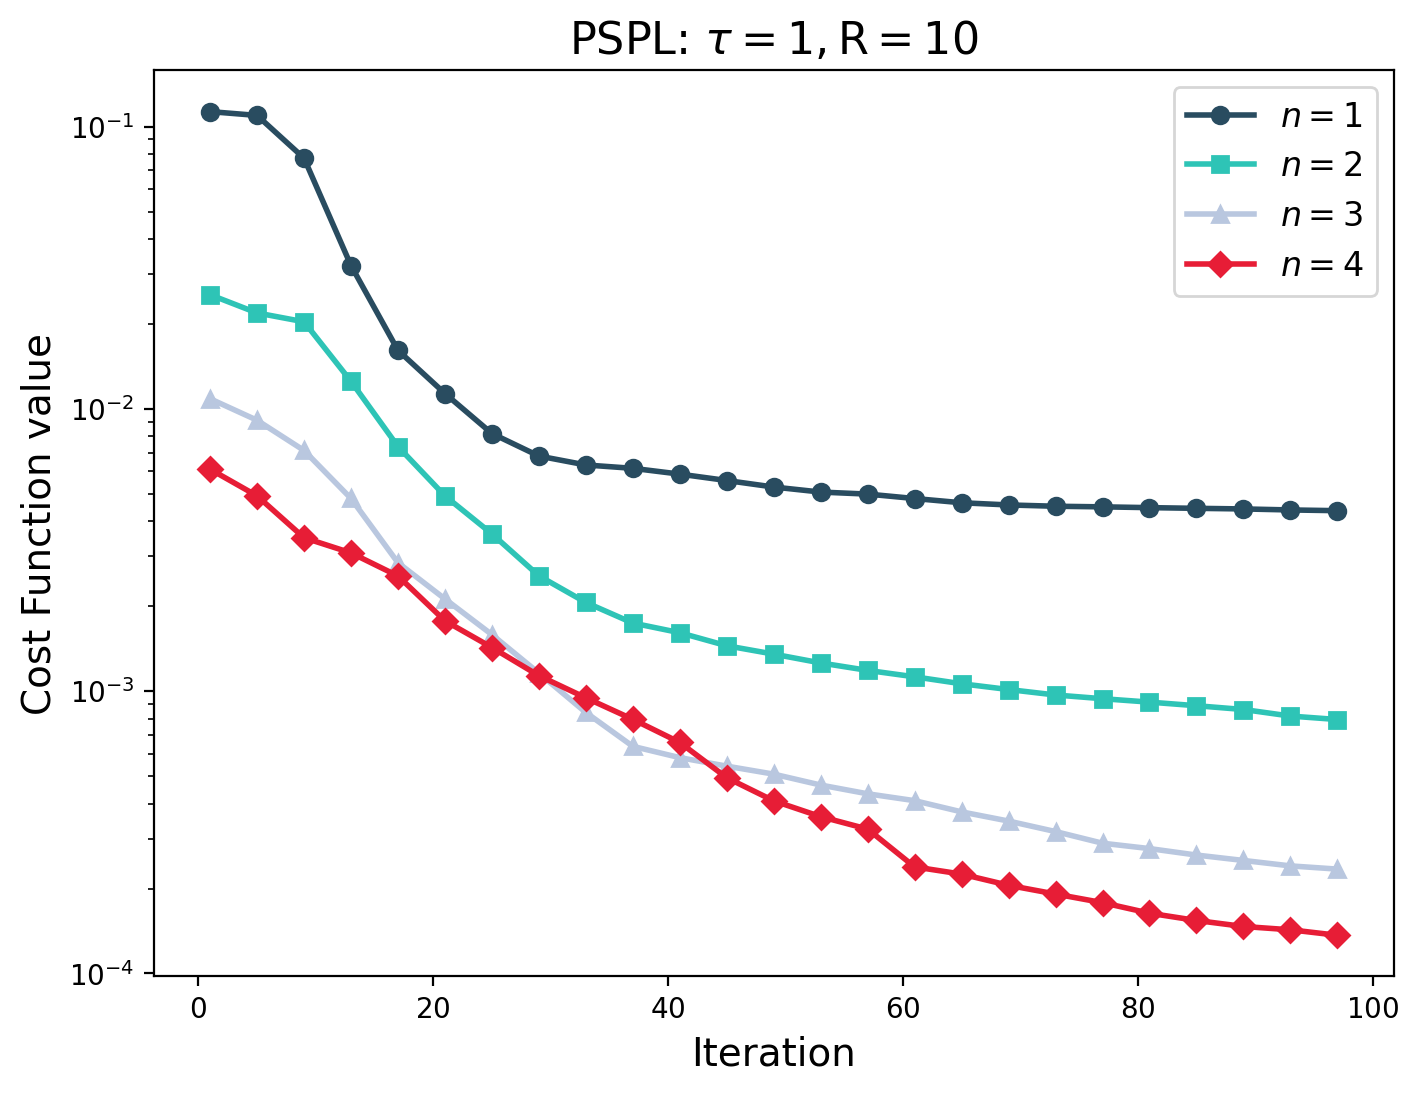

In [360]:
labels = [rf"$n = {i}$" for i in range(1,5)]
title = r"PSPL: $\tau = 1, \mathrm{R}=10$"
fig = plot_pretty(ydatas=f_stiefel_ts,
            labels=labels,
            ylabel="Cost Function value",
            xlabel="Iteration",
            use_semilogy=True,
            idx_main=0,
            integers=False,
            legend_out=False,
            optimize=True,
            marker_step=4,
            title=title,
            )
fig.savefig('../images/thesis/cost_pauli_timesteps_convergence.pdf')

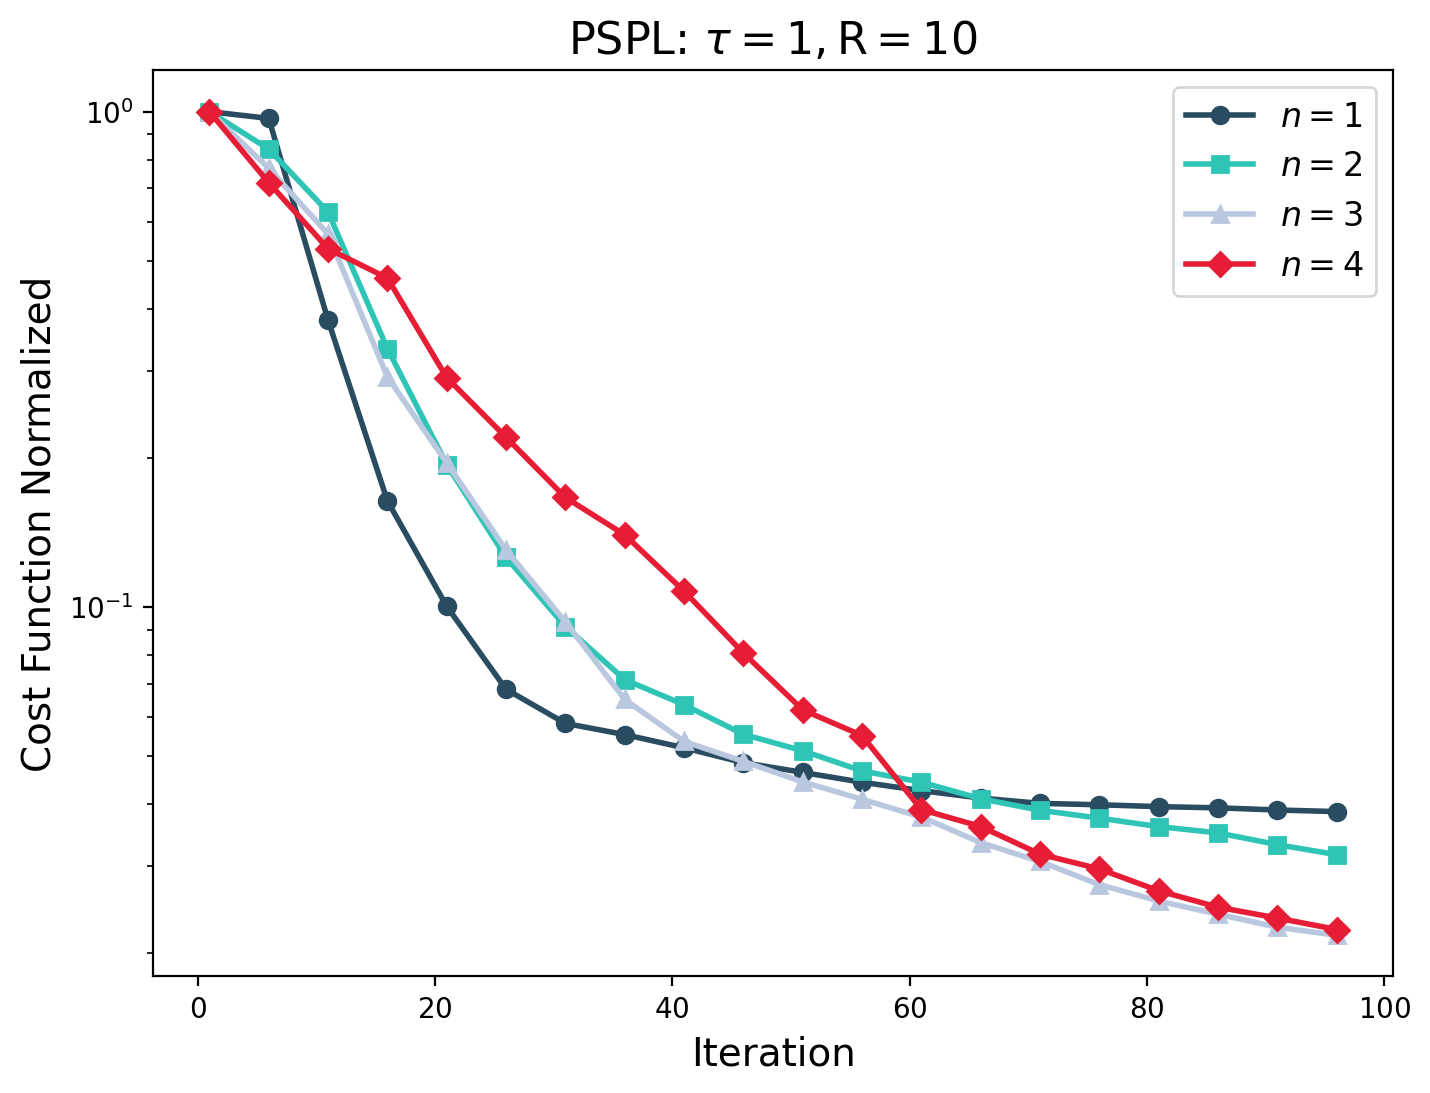

In [361]:
labels = [rf"$n = {i}$" for i in range(1,5)]
title = r"PSPL: $\tau = 1, \mathrm{R}=10$"
fig = plot_pretty(ydatas=ratios_ts,
            labels=labels,
            ylabel="Cost Function Normalized",
            xlabel="Iteration",
            use_semilogy=True,
            idx_main=0,
            integers=False,
            legend_out=False,
            optimize=True,
            marker_step=5,
            title=title
            )
fig.savefig('../images/thesis/cost_pauli_timesteps_convergence_scaled.pdf')

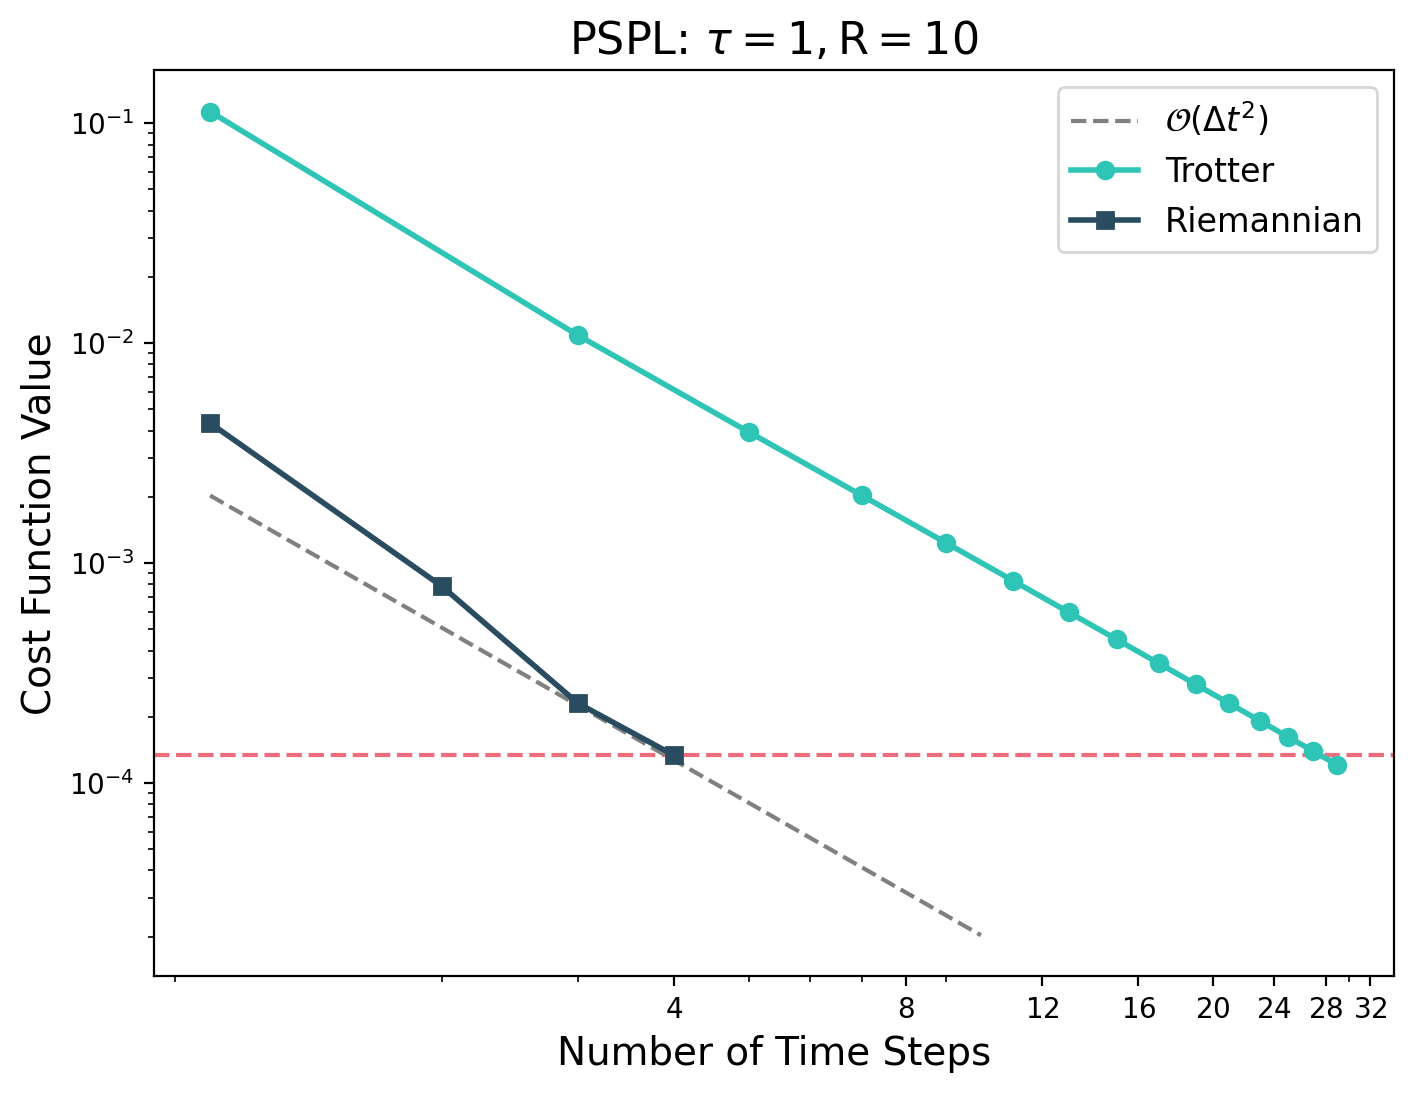

In [68]:
# a = 2.1**(-3)
a = 7.9**(-3)
x_smooth = np.linspace(1, 10, 10) # NOTE: this x is somewhat wrong,the correct one np.linspace(1, 10, 10)
y_smooth = a*x_smooth**(-2)
error_functions = [error_trotter, error_stiefel]

labels = ["Trotter","Riemannian"]
title = r"PSPL: $\tau = 1, \mathrm{R}=10$"
fig = plot_pretty(ydatas=error_functions,
            labels=labels,
            ylabel="Cost Function Value",
            xlabel="Number of Time Steps",
            title=title,
            loglog=True,
            idx_main=1,
            integers=True,
            legend_out=False,
            comparison_value=(x_smooth,y_smooth),
            comparison_label=r"$\mathcal{O}(\Delta t^2)$",
            horizontal_value=error_stiefel[-1],
            marker_step=2,
            )
# fig.savefig('../images/thesis/cost_pauli_timesteps.pdf', bbox_inches='tight')

# Creating the structure preserving superoperators



In [93]:
from opentn.structure_preserving import unnormalized_scheme_error
# tau = 1, Li = [L0, L1], Lvec = Lvec_full
number_timesteps = list(range(1,20))
timesteps = [tau/n for n in number_timesteps]
error_order_1 = [unnormalized_scheme_error(Lvec=Lvec_full, lindbladians=Li, N=N, d=d, tau=tau, n=n, order=1) for n in number_timesteps]
error_order_2 = [unnormalized_scheme_error(Lvec=Lvec_full, lindbladians=Li, N=N, d=d, tau=tau, n=n, order=2) for n in number_timesteps]
error_order_3 = [unnormalized_scheme_error(Lvec=Lvec_full, lindbladians=Li, N=N, d=d, tau=tau, n=n, order=3, verbose=True) for n in number_timesteps]

currently using tau=1, n=1, M=3
currently using tau=1, n=2, M=3
currently using tau=1, n=3, M=3
currently using tau=1, n=4, M=3
currently using tau=1, n=5, M=3
currently using tau=1, n=6, M=3
currently using tau=1, n=7, M=3
currently using tau=1, n=8, M=3
currently using tau=1, n=9, M=3
currently using tau=1, n=10, M=3
currently using tau=1, n=11, M=3
currently using tau=1, n=12, M=3
currently using tau=1, n=13, M=3
currently using tau=1, n=14, M=3
currently using tau=1, n=15, M=3
currently using tau=1, n=16, M=3
currently using tau=1, n=17, M=3
currently using tau=1, n=18, M=3
currently using tau=1, n=19, M=3


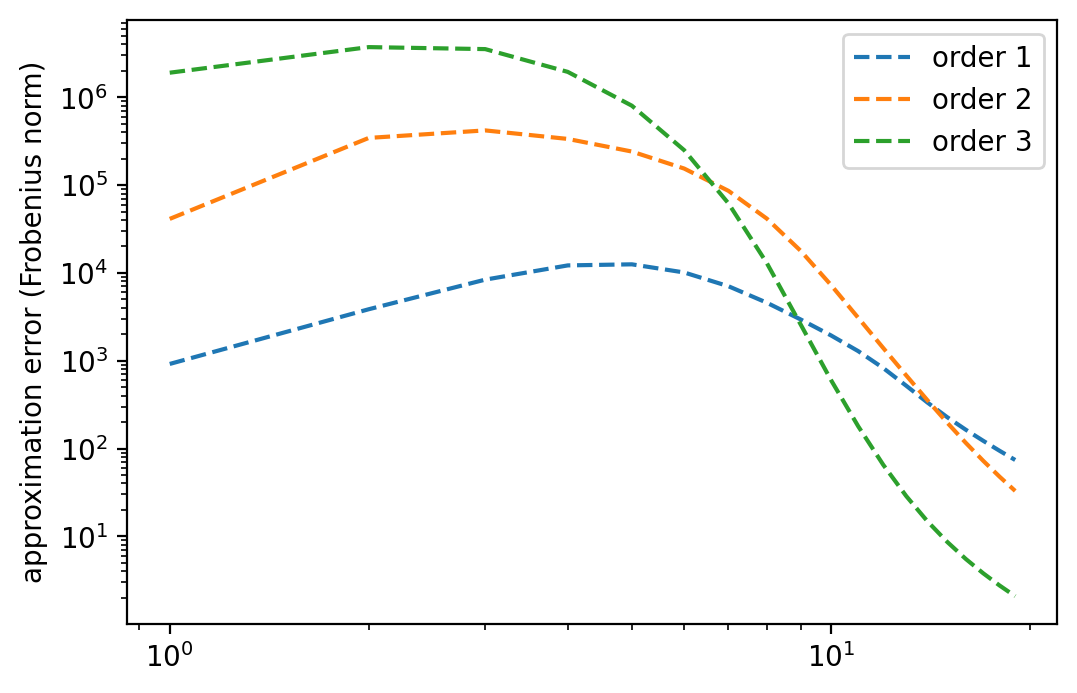

In [94]:
fig = plt.figure(dpi=200)
plt.ylabel('approximation error (Frobenius norm)')
ax = plt.gca()

plt.loglog(number_timesteps, error_order_1, '--', label='order 1')
plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_3, '--', label='order 3')

plt.legend()

In [31]:
# ok, wth is going on?? Let's look at the trace. This might be the issue?
from opentn.structure_preserving import composition, unnormalized_scheme
num_timesteps_scheme = 30
superop_ord_1_ts_0 = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=1), n=n) for n in range(1, num_timesteps_scheme + 1)]
superop_ord_2_ts_0 = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=2), n=n) for n in range(1, num_timesteps_scheme + 1)]
# superop_ord_3_ts_0 = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=3, verbose=True), n=n) for n in range(1, num_timesteps_scheme + 1)]

currently using dt=1.0, M=3
currently using dt=0.5, M=3
currently using dt=0.3333333333333333, M=3
currently using dt=0.25, M=3
currently using dt=0.2, M=3
currently using dt=0.16666666666666666, M=3
currently using dt=0.14285714285714285, M=3
currently using dt=0.125, M=3
currently using dt=0.1111111111111111, M=3
currently using dt=0.1, M=3
currently using dt=0.09090909090909091, M=3
currently using dt=0.08333333333333333, M=3
currently using dt=0.07692307692307693, M=3
currently using dt=0.07142857142857142, M=3
currently using dt=0.06666666666666667, M=3
currently using dt=0.0625, M=3
currently using dt=0.058823529411764705, M=3
currently using dt=0.05555555555555555, M=3
currently using dt=0.05263157894736842, M=3
currently using dt=0.05, M=3
currently using dt=0.047619047619047616, M=3
currently using dt=0.045454545454545456, M=3
currently using dt=0.043478260869565216, M=3
currently using dt=0.041666666666666664, M=3
currently using dt=0.04, M=3
currently using dt=0.038461538461

In [32]:
# ok, wth is going on?? Let's look at the trace. This might be the issue?
from opentn.structure_preserving import composition, unnormalized_scheme
num_timesteps_scheme_extend = 20
superop_ord_1_ts = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=1), n=n) for n in range(num_timesteps_scheme + 1, num_timesteps_scheme + num_timesteps_scheme_extend + 1)]
superop_ord_2_ts = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=2), n=n) for n in range(num_timesteps_scheme + 1, num_timesteps_scheme + num_timesteps_scheme_extend + 1)]
# superop_ord_3_ts = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=3, verbose=True), n=n) for n in range(num_timesteps_scheme + 1,  num_timesteps_scheme + num_timesteps_scheme_extend + 1)]

currently using dt=0.03225806451612903, M=3
currently using dt=0.03125, M=3
currently using dt=0.030303030303030304, M=3
currently using dt=0.029411764705882353, M=3
currently using dt=0.02857142857142857, M=3
currently using dt=0.027777777777777776, M=3
currently using dt=0.02702702702702703, M=3
currently using dt=0.02631578947368421, M=3
currently using dt=0.02564102564102564, M=3
currently using dt=0.025, M=3
currently using dt=0.024390243902439025, M=3
currently using dt=0.023809523809523808, M=3
currently using dt=0.023255813953488372, M=3
currently using dt=0.022727272727272728, M=3
currently using dt=0.022222222222222223, M=3
currently using dt=0.021739130434782608, M=3
currently using dt=0.02127659574468085, M=3
currently using dt=0.020833333333333332, M=3
currently using dt=0.02040816326530612, M=3
currently using dt=0.02, M=3


In [34]:
num_timesteps_scheme_higher = 10
# superop_ord_4_ts = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=4, verbose=True), n=n) for n in range(1, num_timesteps_scheme_higher + 1)]

currently using dt=1.0, M=4
currently using dt=0.5, M=4
currently using dt=0.3333333333333333, M=4
currently using dt=0.25, M=4
currently using dt=0.2, M=4
currently using dt=0.16666666666666666, M=4
currently using dt=0.14285714285714285, M=4
currently using dt=0.125, M=4
currently using dt=0.1111111111111111, M=4
currently using dt=0.1, M=4


In [159]:
# superop_ord_4_ts_2 = [composition(unnormalized_scheme(lindbladians=Li, N=N, d=d, dt=tau/n, order=4, verbose=True), n=n) for n in range(num_timesteps_scheme_higher + 1, 2 * num_timesteps_scheme_higher + 1)]

currently using dt=0.09090909090909091, M=4
currently using dt=0.08333333333333333, M=4
currently using dt=0.07692307692307693, M=4
currently using dt=0.07142857142857142, M=4
currently using dt=0.06666666666666667, M=4
currently using dt=0.0625, M=4
currently using dt=0.058823529411764705, M=4
currently using dt=0.05555555555555555, M=4
currently using dt=0.05263157894736842, M=4
currently using dt=0.05, M=4


# Gather data

In [35]:
superop_ord_4_ts_2 = np.load("superop_ord_4_ts_2.npy")

In [197]:
len(superop_ord_4_ts_2)

10

In [87]:
# non optimized (suzuki)
from opentn.optimization import get_general_trotter_local_ansatz, model_stiefel_local
from opentn.transformations import super2ortho


num_timesteps_scheme = 40
superop_nonopt_ts = []
for n in range(1, num_timesteps_scheme + 1):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=n)]
    superop_nonopt_ts.append(model_stiefel_local(xs_trotter_ts, N, d))

In [86]:
xs_stiefel_ts = [xs_timestep_1_opt_4, xs_timestep_2_opt_4_loaded, xs_timestep_3_opt_6_loaded, xs_timestep_4_opt_9]
superop_stiefel_ts = [model_stiefel_local(xs, N, d) for xs in xs_stiefel_ts]

30

# checking the ranks of the optimized superoperators

In [393]:
print('Non optimized')
for i, superop in enumerate(superop_nonopt_ts[:4]):
    print(f'n={i+1} : {np.linalg.matrix_rank(super2choi(superop))} ')

print('----------')
print('Optimized')
for i, superop in enumerate(superop_stiefel_ts):
    print(f'n={i+1} : {np.linalg.matrix_rank(super2choi(superop))} ')

Non optimized
n=1 : 256 
n=2 : 256 
n=3 : 256 
n=4 : 256 
----------
Optimized
n=1 : 256 
n=2 : 256 
n=3 : 256 
n=4 : 256 


In [420]:
print('order 1 SP')
for i, superop in enumerate(superop_ord_1_ts_0[:5]):
    print(f'n={i+1} : {np.linalg.matrix_rank(super2choi(superop))} ')
print('----------')
print('order 2 SP')
for i, superop in enumerate(superop_ord_2_ts_0[:5]):
    print(f'n={i+1} : {np.linalg.matrix_rank(super2choi(superop))} ')
print('----------')
print('order 3 SP')
for i, superop in enumerate(superop_ord_3_ts_0[:5]):
    print(f'n={i+1} : {np.linalg.matrix_rank(super2choi(superop))} ')
print('----------')
print('order 4 SP')
for i, superop in enumerate(superop_ord_4_ts[:5]):
    print(f'n={i+1} : {np.linalg.matrix_rank(super2choi(superop))} ')

order 1 SP
n=1 : 7 
n=2 : 38 
n=3 : 145 
n=4 : 241 
n=5 : 256 
----------
order 2 SP
n=1 : 38 
n=2 : 241 
n=3 : 256 
n=4 : 256 
n=5 : 256 
----------
order 3 SP
n=1 : 96 
n=2 : 256 
n=3 : 256 
n=4 : 256 
n=5 : 256 
----------
order 4 SP
n=1 : 190 
n=2 : 256 
n=3 : 256 
n=4 : 256 
n=5 : 256 


In [386]:
[f_stiefel(xs) for xs in xs_stiefel_ts]

[DeviceArray(0.00433034, dtype=float64),
 DeviceArray(0.00077003, dtype=float64),
 DeviceArray(0.00023033, dtype=float64),
 DeviceArray(0.00013085, dtype=float64)]

In [387]:
[f[-1] for f in f_stiefel_ts]

[0.004330344959560802,
 0.0007821533144168196,
 0.00023033004221166163,
 0.0001333226534792719]

# Save data

In [538]:
# saving the stiefel optimized arrays
np.save(file="xs_timestep_1_opt", arr=np.array(xs_timestep_1_opt))
np.save(file="xs_timestep_2_opt", arr=np.array(xs_timestep_2_opt))
np.save(file="xs_timestep_3_opt", arr=np.array(xs_timestep_3_opt_2))
# saving the stiefel optimized cost functions
np.save(file="f_stiefel_ts", arr=np.array(f_stiefel_ts))
# saving the 4th order superoperator for large number of time steps
np.save(file="superop_ord_4_ts_2", arr=np.array(superop_ord_4_ts_2))


In [33]:
# saving the data for order 3 and 4 initial as well, why didn't I save it before?
np.save(file="superop_ord_3_ts_joined", arr=np.array(superop_ord_3_ts_0 +  superop_ord_3_ts))

In [36]:
np.save(file="superop_ord_4_ts", arr=np.array(superop_ord_4_ts))

# Save latest data: 30th march

In [397]:
# already saved coming from different branch: xs_timestep_1_opt_4, xs_timestep_4_opt_9
np.save(file="xs_pspl_timestep_2_opt_4", arr=xs_timestep_2_opt_4[-1])
np.save(file="xs_pspl_timestep_3_opt_6", arr=xs_timestep_3_opt_6[-1])

# Load the data

In [57]:
# DATE: 17th of July 2024, trying to plot the data again.
# Loading the data from the .npy files
xs_timestep_1_opt_loaded = np.load(file="xs_timestep_1_opt.npy")
xs_timestep_2_opt_loaded = np.load(file="xs_timestep_2_opt.npy")
xs_timestep_3_opt_2_loaded = np.load(file="xs_timestep_3_opt.npy")
xs_timestep_2_opt_4_loaded = np.load(file="xs_pspl_timestep_2_opt_4.npy")

xs_timestep_3_opt_6_loaded = np.load(file="xs_pspl_timestep_3_opt_6.npy")

f_stiefel_ts_loaded = np.load(file="f_stiefel_ts.npy")

superop_ord_4_ts_loaded = np.load(file="superop_ord_4_ts.npy")
superop_ord_4_ts_2_loaded = np.load(file="superop_ord_4_ts_2.npy")

superop_ord_3_ts_loaded = np.load(file="superop_ord_3_ts_joined.npy")


# Unnormalized error

In [195]:
from opentn.structure_preserving import random_psd_error
error_nonopt_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=False)
error_order_1_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts_0 +  superop_ord_1_ts, normalize=False)
error_order_2_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts_0 +  superop_ord_2_ts, normalize=False)
error_order_3_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts_0 +  superop_ord_3_ts, normalize=False)

In [196]:
error_stiefel_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts, normalize=False)


In [216]:
error_order_4_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_4_ts + list(superop_ord_4_ts_2), normalize=False)

In [218]:
errors_unnorm = [error_nonopt_unnorm, error_stiefel_unnorm, error_order_1_unnorm, error_order_2_unnorm, error_order_3_unnorm, error_order_4_unnorm]

# Normalized Error

In [53]:
from opentn.structure_preserving import random_psd_error

error_order_1_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts_0 + superop_ord_1_ts, normalize=True)
error_order_2_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts_0 + superop_ord_2_ts, normalize=True)
error_order_3_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts_loaded, normalize=True)

In [88]:
error_nonopt_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=True)

In [54]:
error_stiefel_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts, normalize=True)

In [58]:
error_order_4_norm = random_psd_error(superop_exact=exp_Lvec, superops_error=list(superop_ord_4_ts_loaded) + list(superop_ord_4_ts_2_loaded), normalize=True)

In [90]:
errors_norm = [error_nonopt_norm, error_stiefel_norm, error_order_1_norm, error_order_2_norm, error_order_3_norm, error_order_4_norm]

# Plotting

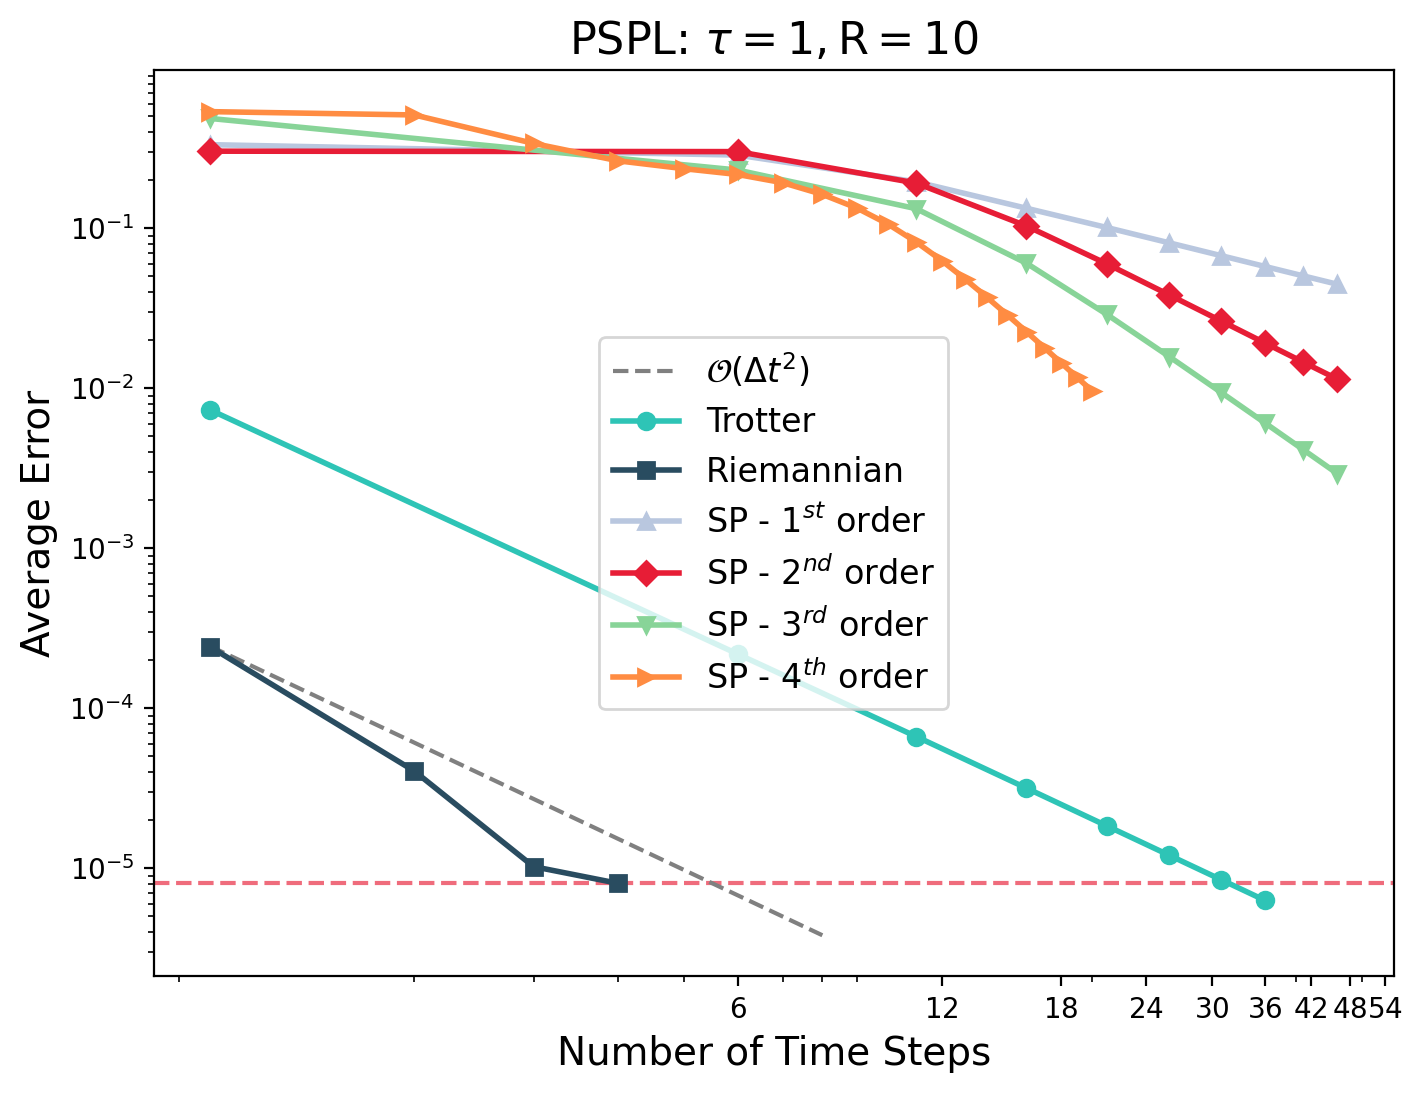

In [96]:
labels = ['Trotter', 'Riemannian', r'SP - $1^{st}$ order', r'SP - $2^{nd}$ order', r'SP - $3^{rd}$ order', r'SP - $4^{th}$ order'][:]
title = r"PSPL: $\tau = 1, \mathrm{R}=10$"

a = 16**(-3)
x_smooth = np.linspace(1, 8, 10)
y_smooth = a*x_smooth**(-2)

fig = plot_pretty(
    errors_norm,
    labels=labels,
    ylabel="Average Error",
    xlabel="Number of Time Steps",
    title=title,
    loglog=True,
    integers=True,
    idx_main=1,
    legend_out=False,
    comparison_value=(x_smooth,y_smooth),
    comparison_label=r"$\mathcal{O}(\Delta t^2)$",
    horizontal_value=error_stiefel_norm[-1],
    )
# fig.savefig('../images/thesis/final_comparison_pauli.pdf', bbox_inches='tight')

In [97]:
fig.savefig('../images/thesis/final_comparison_pauli_paper.pdf', bbox_inches='tight')

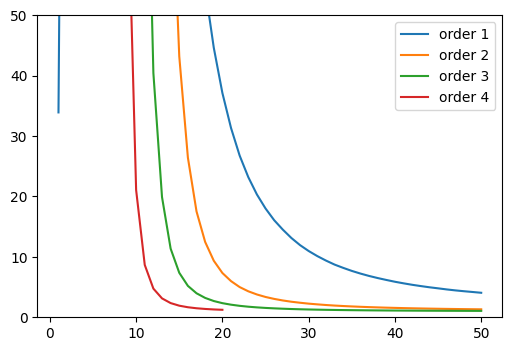

In [187]:
from opentn.structure_preserving import compute_trace_superop
traces_ord_1 = []
traces_ord_2 = []
traces_ord_3 = []
traces_ord_4 = []


for superop in superop_ord_1_ts_0 + superop_ord_1_ts:
    traces_ord_1.append(compute_trace_superop(superop))

for superop in superop_ord_2_ts_0 + superop_ord_2_ts:
    traces_ord_2.append(compute_trace_superop(superop))

for superop in superop_ord_3_ts_0 + superop_ord_3_ts:
    traces_ord_3.append(compute_trace_superop(superop))

for superop in superop_ord_4_ts +  superop_ord_4_ts_2:
    traces_ord_4.append(compute_trace_superop(superop))

fig = plt.figure(dpi=100)
plt.ylim(0,50)
plt.plot(range(1, len(traces_ord_1) + 1), traces_ord_1, label='order 1')
plt.plot(range(1, len(traces_ord_2) + 1), traces_ord_2, label='order 2')
plt.plot(range(1, len(traces_ord_3) + 1), traces_ord_3, label='order 3')
plt.plot(range(1, len(traces_ord_4) + 1), traces_ord_4, label='order 4')
plt.legend()

# lets do the whole thing again but with different pauli channel

In [22]:
tau_sp = 4
gamma_sp = 2
L0 = np.sqrt(gamma_sp)*(np.kron(X, X))
L1 = np.sqrt(gamma_sp)*(np.kron(Z, Z))
Li_sp = [L0, L1]

Lvec_full_sp, Lvec_odd_full_sp, Lvec_even_full_sp = create_2local_liouvillians(Li=Li_sp, N=N, d=d, pbc=True)
exp_Lvec_sp, exp_Lvec_odd_sp, exp_Lvec_even_sp = create_trotter_layers([Lvec_full_sp, Lvec_odd_full_sp, Lvec_even_full_sp], tau=tau_sp)

Eks = choi2kraus(super2choi(exp_Lvec_sp), tol=1e-15)
print(len(Eks))
Eks_even = choi2kraus(super2choi(exp_Lvec_even_sp), tol=1e-15)
print(len(Eks_even))

f_stiefel_sp = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d), exp_Lvec_sp)
grad_stiefel_sp = lambda xi: gradient_stiefel_vec(xi, f_stiefel_sp, metric='canonical')
hessian_stiefel_sp = lambda xi: riemannian_hessian_vec(xi, f_stiefel_sp, metric='canonical')

64
16


In [23]:
Lvec_odd_full_sp_test = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
Lvec_even_full_sp_test = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for op in Li_sp:
   _, Lvec_odd, Lvec_even = create_2local_liouvillians(Li=op, N=N, d=d, pbc=True)
   Lvec_odd_full_sp_test += Lvec_odd
   Lvec_even_full_sp_test += Lvec_even
Lvec_full_sp_test = Lvec_odd_full_sp_test + Lvec_even_full_sp_test
for op1, op2 in zip(create_2local_liouvillians(Li=Li_sp, N=N, d=d, pbc=True), [Lvec_full_sp_test, Lvec_odd_full_sp_test, Lvec_even_full_sp_test]):
    print(np.allclose(op1, op2))

True
True
True


In [24]:
rank_sp = np.linalg.matrix_rank(super2choi(get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=1)[0]))
rank_sp

4

In [366]:
xs_timestep_1_sp = [super2ortho(x.real, rank=rank_sp) for x in get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=1)]
print(f_stiefel_sp(xs_timestep_1_sp))

0.0023241536763024028


In [301]:
xs_timestep_1_sp_opt, f_timestep_1_sp_opt, radius_timestep_1_sp_opt = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_1_sp, save_x=True, niter=20)

0.0023241536763024028


In [306]:
len(xs_timestep_1_sp), np.allclose(xs_timestep_1_sp[0], xs_timestep_1_sp[2])

(3, True)

In [292]:
xs_timestep_2_sp = [super2ortho(x.real, rank=rank_sp) for x in get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=2)]
print(f_stiefel_sp(xs_timestep_2_sp))

xs_timestep_2_sp_opt, f_timestep_2_sp_opt, radius_timestep_2_sp_opt = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_2_sp, save_x=True, niter=20)

0.0023241536763024015
iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0023241536763024015
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0021150119929228047
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.001738802582541618
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011357341360306152
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.00625
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.0015625
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.000390625
iteration: 8
column : 0
colu

In [318]:
len(xs_timestep_2_sp), np.allclose(xs_timestep_2_sp[1], xs_timestep_2_sp[3])

(5, True)

In [297]:
xs_timestep_2_sp_opt_2, f_timestep_2_sp_opt_2, radius_timestep_2_sp_opt_2 = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_2_sp_opt[-1], save_x=True, niter=20, radius_init=radius_timestep_2_sp_opt)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00021017522595502184
radius 0.0015625
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00021017522595502184
radius 0.0015625
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00016454900125890254
radius 0.003125
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0001496618331500881
radius 0.00625
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00013962077090123707
radius 0.0125
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00012611367154199258
radius 0.025
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 8.719163648140533e-05
radius 0.025
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 5.626614184600908e-05
radius 0.00625
iteration: 8
column : 0
column : 1


In [322]:
xs_timestep_3_sp = [super2ortho(x.real, rank=rank_sp) for x in get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=3)]
print(f_stiefel_sp(xs_timestep_3_sp))

xs_timestep_3_sp_opt, f_timestep_3_sp_opt, radius_timestep_3_sp_opt = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_3_sp, save_x=True, niter=40)

0.0023241536763024084
iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0023241536763024084
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0021875912091689135
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0019341730538746948
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0014995514115975805
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0008855869799755074
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005101877577164558
radius 0.025
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005101877577164558
radius 0.00625
ite

In [325]:
ratios_ts_1_sp = [cost for cost in f_timestep_1_sp_opt]
ratios_ts_2_sp = [cost for cost in f_timestep_2_sp_opt + f_timestep_2_sp_opt_2]
ratios_ts_3_sp = [cost for cost in f_timestep_3_sp_opt]



In [356]:
error_suzuki_sp = [compute_trotter_approximation_error(d=d, N=N, tau=tau_sp, n=n, Li=Li_sp) for n in range(1,10)]
error_stiefel_sp = [values[-1] for values in [f_timestep_1_sp_opt, f_timestep_2_sp_opt_2, f_timestep_3_sp_opt]]

In [365]:
compute_trotter_approximation_error(d=d, N=N, tau=tau_sp, n=1, Li=Li_sp)

4


DeviceArray(2.32708612e-15, dtype=float64)

In [358]:
error_suzuki_sp

[DeviceArray(2.32708612e-15, dtype=float64),
 DeviceArray(2.75919174e-15, dtype=float64),
 DeviceArray(1.48692794e-15, dtype=float64),
 DeviceArray(1.62613598e-14, dtype=float64),
 DeviceArray(2.1490605e-14, dtype=float64),
 DeviceArray(4.00056334e-14, dtype=float64),
 DeviceArray(1.95649181e-14, dtype=float64),
 DeviceArray(5.86724662e-14, dtype=float64),
 DeviceArray(1.22600839e-14, dtype=float64)]

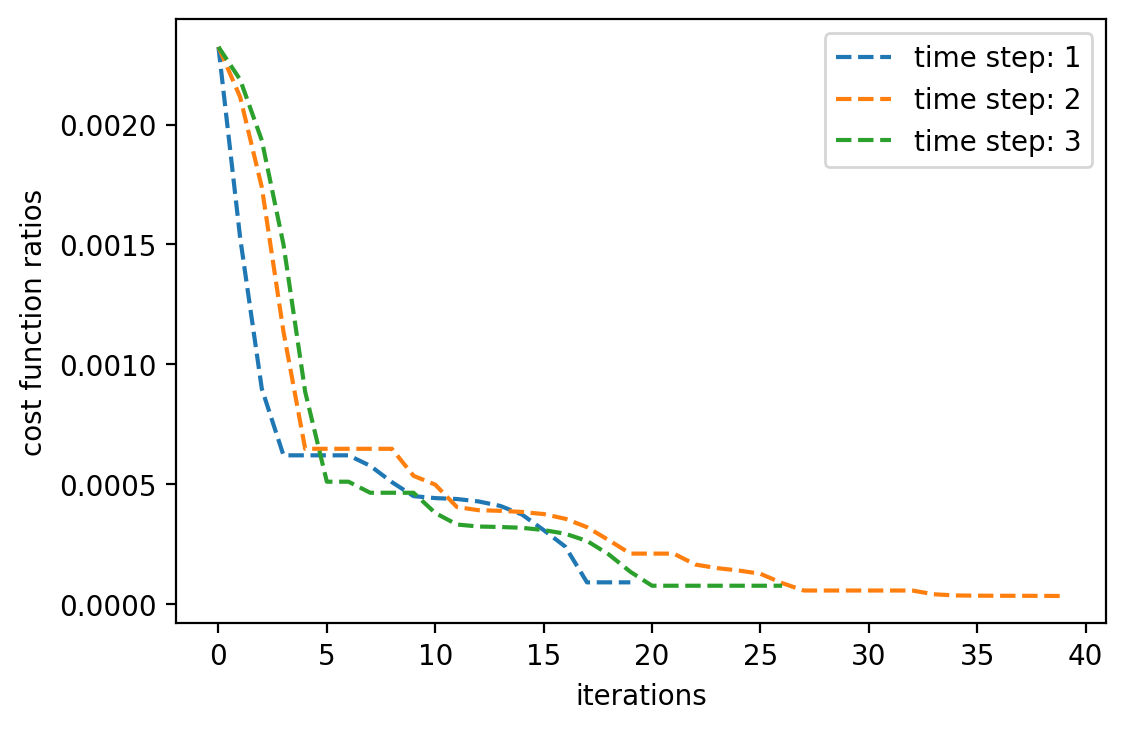

In [354]:
plt.figure(dpi=200)
plt.ylabel('cost function ratios')
plt.xlabel('iterations')
plt.plot(ratios_ts_1_sp, '--', label='time step: 1')
plt.plot(ratios_ts_2_sp, '--', label='time step: 2')
plt.plot(ratios_ts_3_sp, '--', label='time step: 3')
plt.legend()

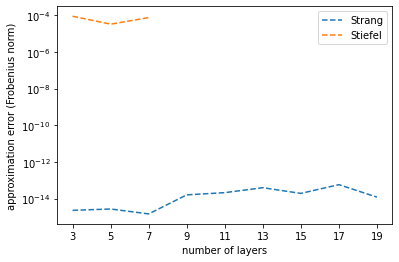

In [357]:
ax = plt.gca()
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('number of layers')
plt.semilogy(error_suzuki_sp, '--', label='Strang')
plt.semilogy(error_stiefel_sp, '--', label='Stiefel')
set_discrete_labels(labels=[str(index) for index in (2*np.arange(1,len(error_suzuki_sp)+1) + 1)], ax=ax, rotation=0)
plt.legend()